In [ ]:
# required for colab only
from google.colab import files
uploaded = files.upload()

Saving wind_SUD.csv to wind_SUD.csv


# Exploratory analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from scipy.signal import periodogram

In [ ]:
zone = 'SUD'
PATH = f'wind_{zone}.csv'
data = pd.read_csv(PATH)

In [ ]:
# convert date to format datetime
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

<ipython-input-4-be3e7cecb851>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['date'] = pd.to_datetime(df['date'])


In [ ]:
# complete all the datetimes
all_datetimes = pd.DataFrame(pd.date_range(datetime(df.date.min().year, 1, 1), df.date.max(), freq='d'), columns=["date"])
df = all_datetimes.merge(df, on=['date'], how='outer')
df.set_index('date', inplace=True)

In [ ]:
# fill the missing values with the closest available data
df.energy = df.energy.fillna(method='ffill').fillna(method='bfill')

In [ ]:
# check if every year has 365 data points (except the last year)
df = df.reset_index(drop=False)
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df.set_index('date', inplace=True)

count_year_df = df.groupby('year')['energy'].count()

In [ ]:
# use only complete years
condition = count_year_df >= 365
complete_years = count_year_df.loc[condition].index
df = df.loc[df.year.isin(complete_years)]
df

energy  year
date                    
2015-01-01    61.5  2015
2015-01-02    61.5  2015
2015-01-03    20.8  2015
2015-01-04    44.8  2015
2015-01-05    40.3  2015
...            ...   ...
2021-12-27    15.6  2021
2021-12-28    24.3  2021
2021-12-29     3.6  2021
2021-12-30    18.8  2021
2021-12-31     9.8  2021

[2557 rows x 2 columns]

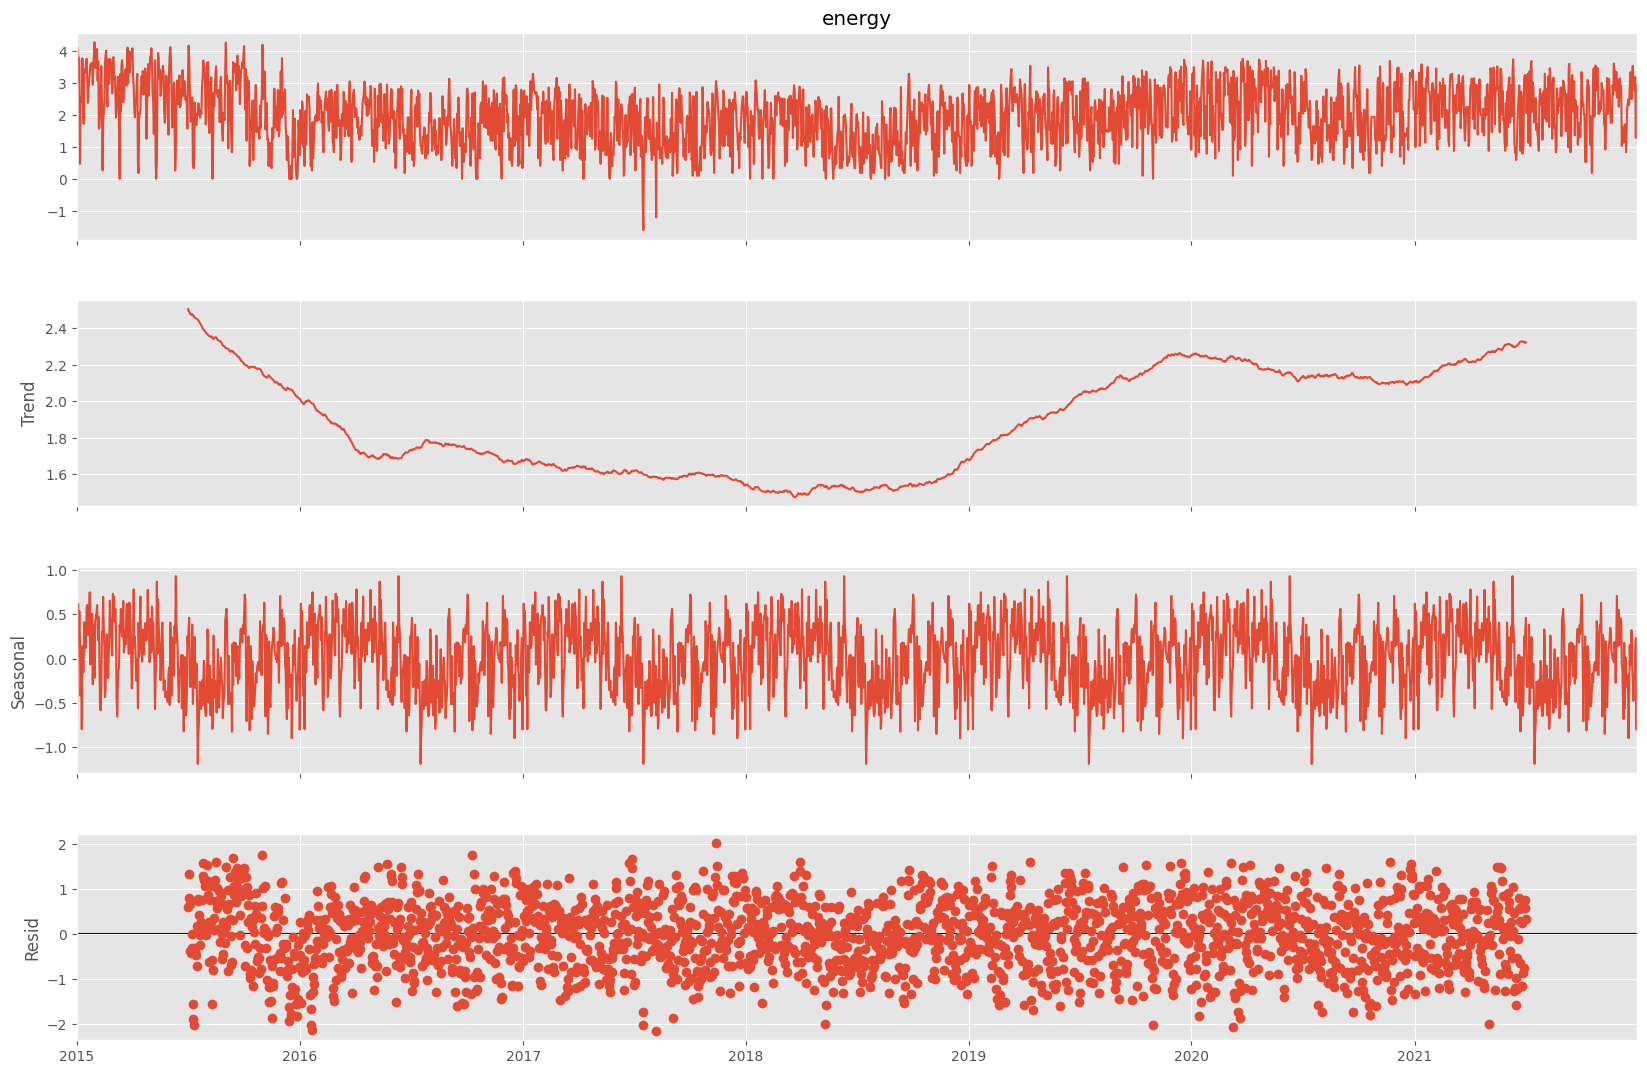

In [ ]:
dflog = np.log(df.loc[df.year < 2022, 'energy'])

res = seasonal_decompose(dflog, model='additive', period=365)
fig = res.plot()
fig.set_size_inches((18,12))
plt.show()

In [ ]:
# fit an ARIMA model and plot residual errors
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
x = res.resid
dates0 = df.loc[df.year <= 2022].index
x.index=dates0
x.dropna().values

array([0.60524484, 1.33221444, 0.80007401, ..., 0.76701092, 0.57936977,
       0.33417766])

In [ ]:
# fit model
x = res.resid
dates0 = df.loc[df.year < 2022].index
x.index=dates0
x = x.dropna()
model = ARIMA(x, order=(5,1,0))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                 2193
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2402.969
Date:                Mon, 27 Nov 2023   AIC                           4817.939
Time:                        22:51:26   BIC                           4852.094
Sample:                    07-02-2015   HQIC                          4830.422
                         - 07-02-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5019      0.021    -23.929      0.000      -0.543      -0.461
ar.L2         -0.3915      0.023    -16.659      0.000      -0.438      -0.345
ar.L3         -0.3010      0.023    -13.026      0.0

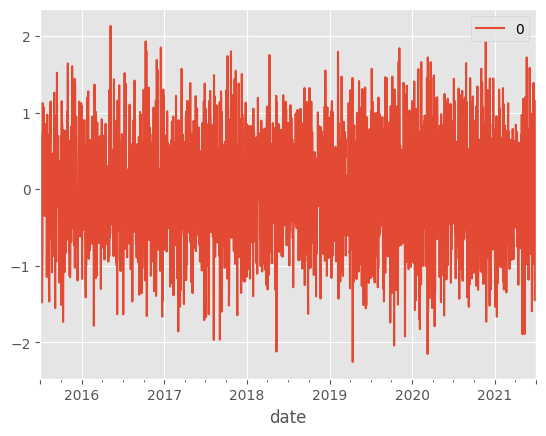

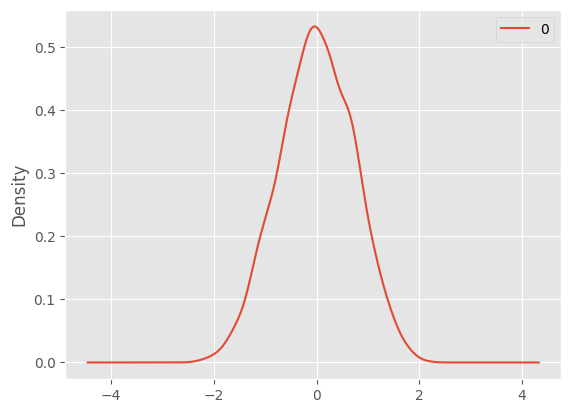

                 0
count  2193.000000
mean     -0.000136
std       0.724285
min      -2.258228
25%      -0.505748
50%      -0.001996
75%       0.527506
max       2.131969


In [ ]:
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

Test RMSE: 0.744


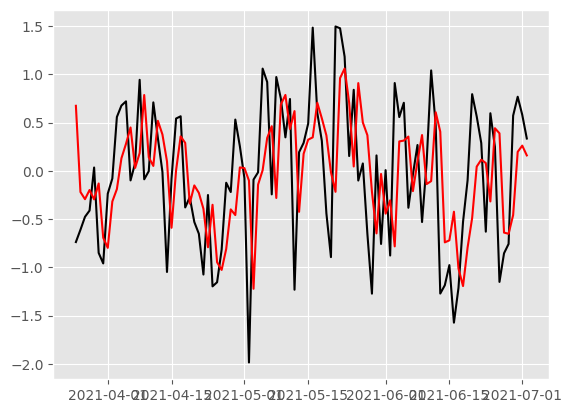

In [ ]:
# split into train and test sets
test_steps = 100
# train = x[:test_steps]
# test = x[test_steps:]
train, test = x[:test_steps], x[-test_steps:]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 # model = SARIMAX(history, trend='c', order=(5,1,0), enforce_stationarity=False, enforce_invertibility=False)
 model = ARIMA(history, order=(5,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 # print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = np.sqrt(np.mean(np.square(test - predictions)))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test, color='k')
plt.plot(test.index, predictions, color='red')
plt.show()

In [ ]:
rmse = np.square(test - predictions)
rmse

date
2015-10-10    0.041744
2015-10-11    2.534152
2015-10-12    0.434621
2015-10-13    0.097543
2015-10-14    0.706045
                ...   
2021-06-28    0.072872
2021-06-29    1.326209
2021-06-30    0.442758
2021-07-01    0.124822
2021-07-02    0.037358
Name: resid, Length: 2093, dtype: float64